In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from amberdata_derivatives import AmberdataDerivatives
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# insert API key below
amberdata_client = AmberdataDerivatives(api_key="")

amberdata_client.get

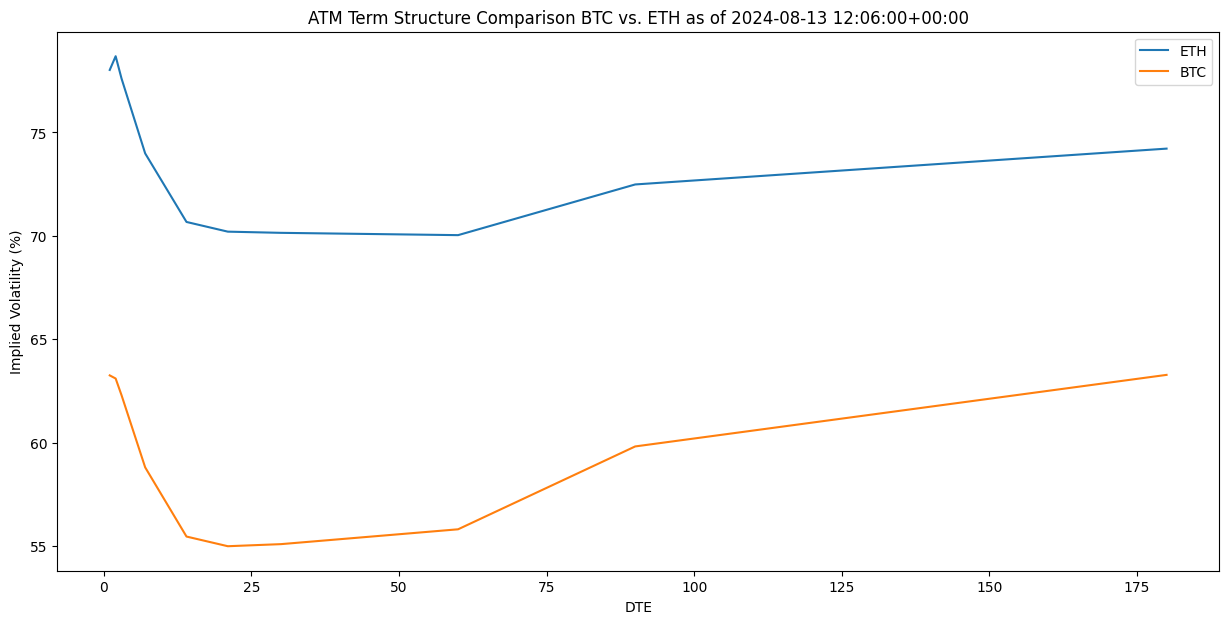

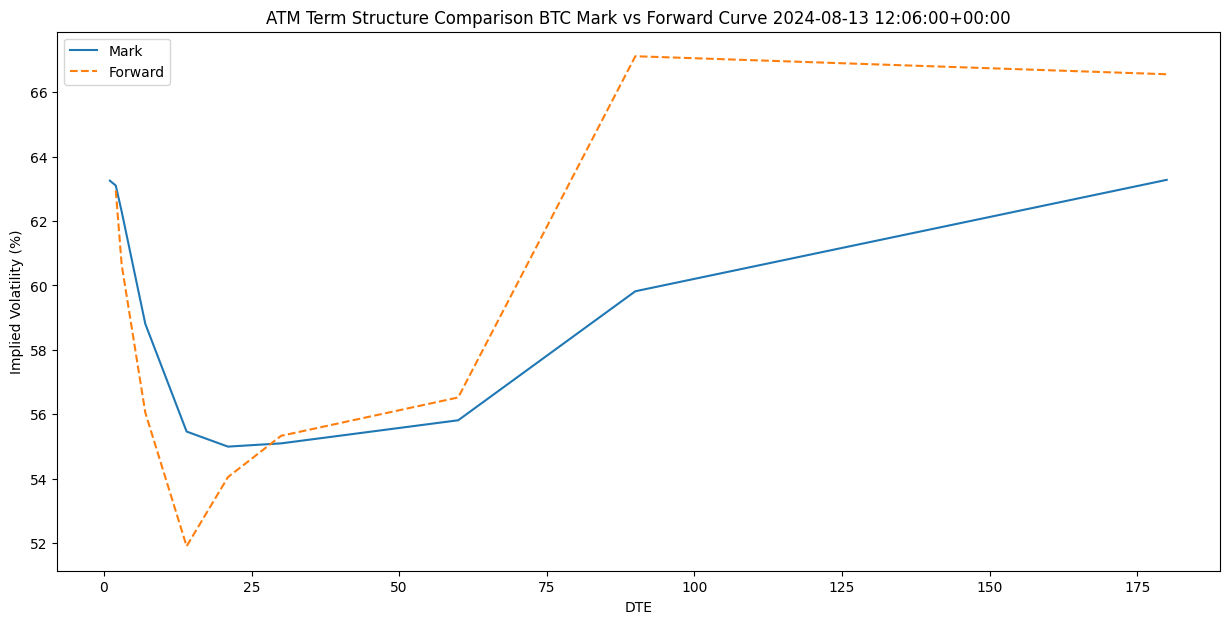

In [3]:
btc = pd.DataFrame(amberdata_client.get_term_structures_constant(currency='BTC', exchange='deribit')['payload']['data'])
eth = pd.DataFrame(amberdata_client.get_term_structures_constant(currency='ETH', exchange='deribit')['payload']['data'])

# plot the atm BTC + ETH term structure
plt.figure(figsize=(15, 7))
plt.plot(eth.daysToExpiration, eth.atm, label='ETH')
plt.plot(btc.daysToExpiration, btc.atm, label='BTC')
plt.title("ATM Term Structure Comparison BTC vs. ETH as of " + str(str(pd.to_datetime(btc.timestamp[0]))))
plt.ylabel("Implied Volatility (%)")
plt.xlabel("DTE")
plt.legend()

# plot BTC atm + atm forward vol
plt.figure(figsize=(15, 7))
plt.plot(btc.daysToExpiration, btc.atm, label='Mark')
plt.plot(btc.daysToExpiration, btc.fwdAtm, label='Forward', linestyle='--')
plt.title("ATM Term Structure Comparison BTC Mark vs Forward Curve " + str(str(pd.to_datetime(btc.timestamp[0]))))
plt.ylabel("Implied Volatility (%)")
plt.xlabel("DTE")
plt.legend();

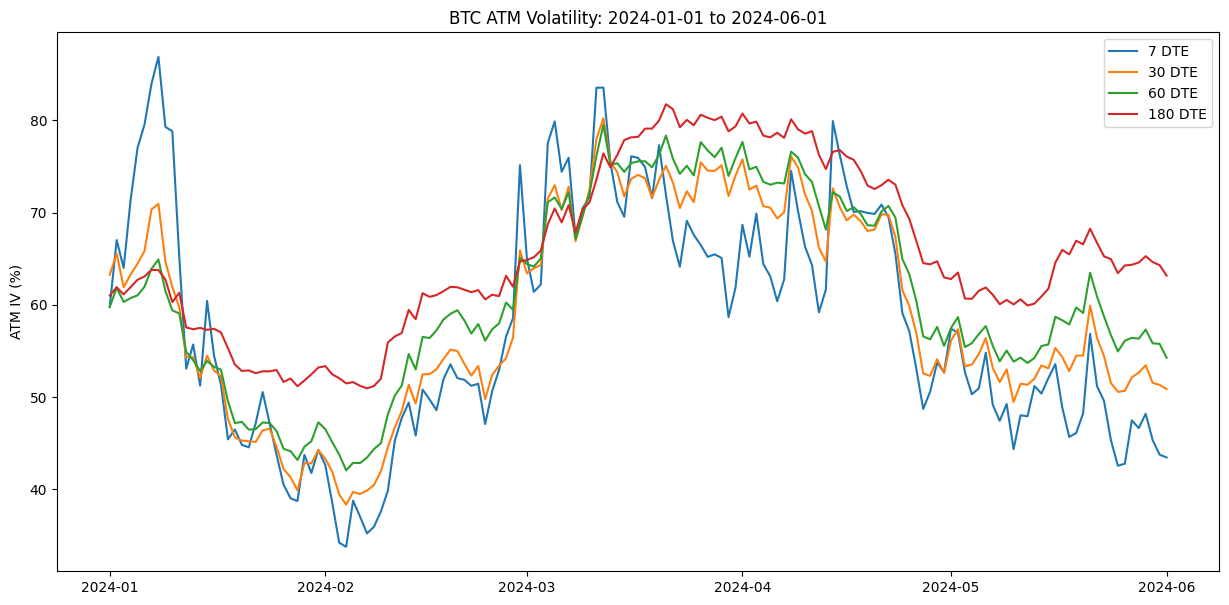

In [5]:
# plot atm BTC volatility
data = amberdata_client.get_delta_surfaces_constant(currency='BTC', exchange='deribit', startDate='2024-01-01', endDate='2024-06-01', timeInterval='day')
data = data['payload']['data']
data = pd.DataFrame(data)

date = pd.to_datetime(data[data.daysToExpiration==7].timestamp)

plt.figure(figsize=(15, 7))
plt.plot(date, data[data.daysToExpiration==7].atm, label='7 DTE')
plt.plot(date, data[data.daysToExpiration==30].atm, label='30 DTE')
plt.plot(date, data[data.daysToExpiration==60].atm, label='60 DTE')
plt.plot(date, data[data.daysToExpiration==180].atm, label='180 DTE')
plt.legend()
plt.title("BTC ATM Volatility: 2024-01-01 to 2024-06-01")
plt.ylabel("ATM IV (%)");

Text(0, 0.5, 'Skew [Call - Put] (%)')

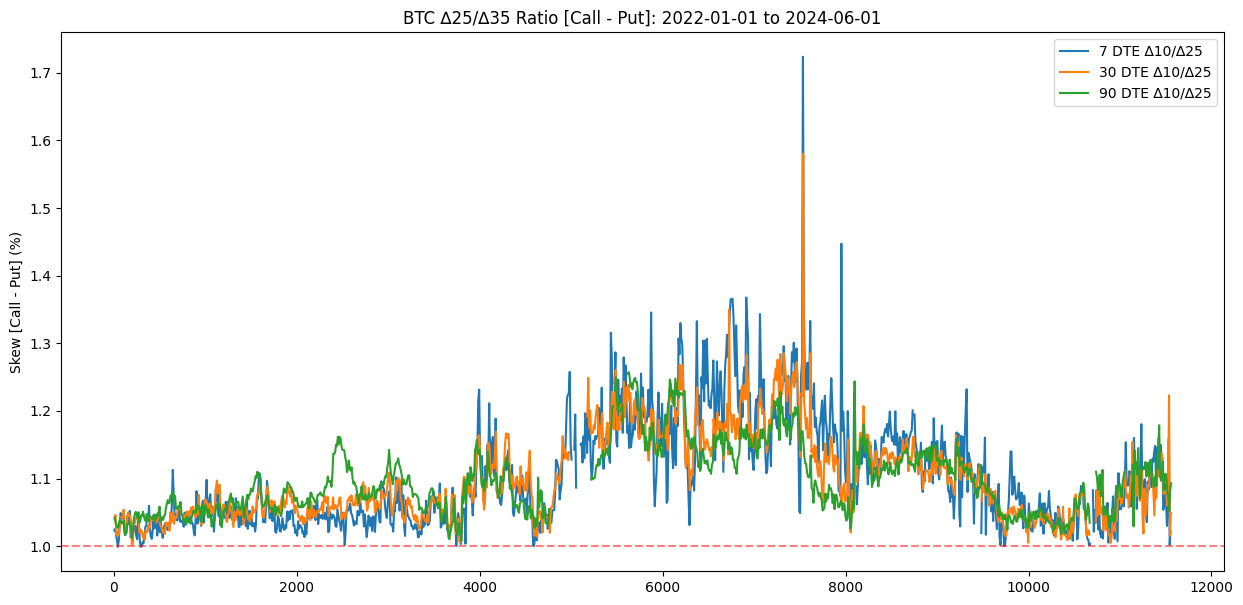

In [6]:
# plot 25 delta BTC skew
data = amberdata_client.get_delta_surfaces_constant(currency='BTC', exchange='deribit', startDate='2019-04-01', endDate='2022-06-01', timeInterval='day')
data = data['payload']['data']
data = pd.DataFrame(data)

s7 = data[data.daysToExpiration==7]
s30 = data[data.daysToExpiration==30]
s90 = data[data.daysToExpiration==90]

plt.figure(figsize=(15, 7))
plt.plot(s7.deltaCall10 / s7.deltaCall25, label='7 DTE ∆10/∆25')
plt.plot(s30.deltaCall10 / s30.deltaCall25, label='30 DTE ∆10/∆25')
plt.plot(s90.deltaCall10 / s90.deltaCall25, label='90 DTE ∆10/∆25')
plt.axhline(1, linestyle='--', c='r', alpha=0.50)
plt.legend()
plt.title("BTC ∆25/∆35 Ratio [Call - Put]: 2022-01-01 to 2024-06-01")
plt.ylabel("Skew [Call - Put] (%)")

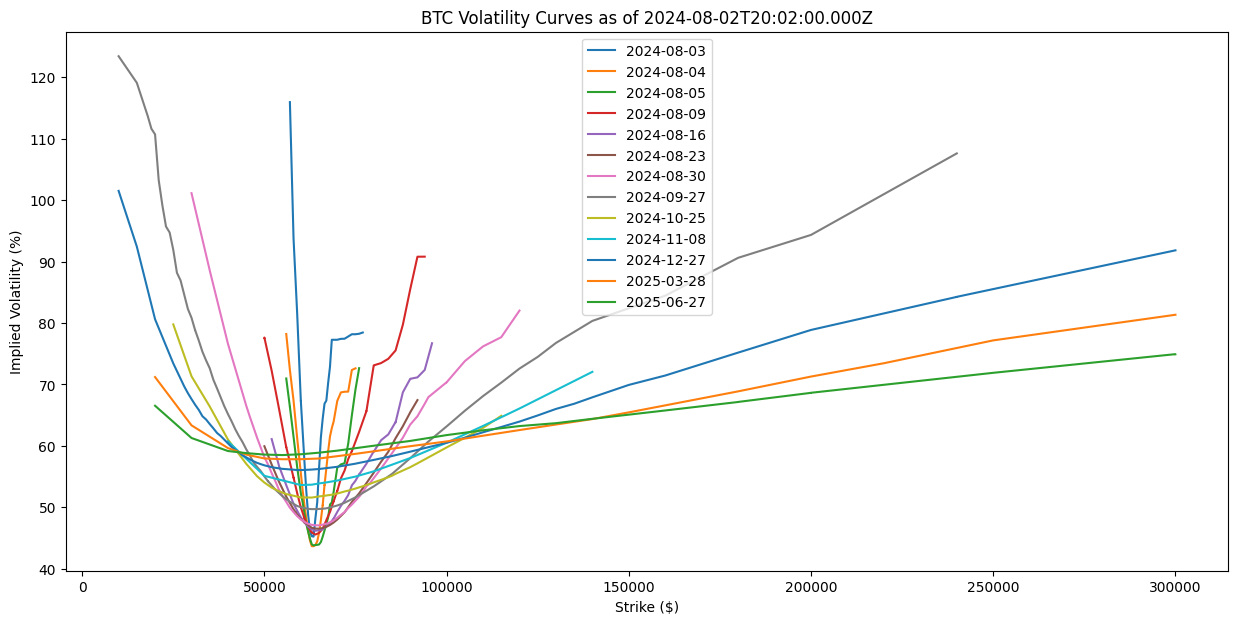

In [8]:
# plot BTC Deribit vol curves 
data = pd.DataFrame(amberdata_client.get_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])
mats = sorted(set(data.expirationTimestamp))

plt.figure(figsize=(15, 7))
for mat in mats:
    sub = data[data.expirationTimestamp == mat]
    sub = sub.sort_values("strike").reset_index(drop=True)
    
    plt.plot(sub.strike, sub.markIv, label=mat[:10])
    plt.legend()
    plt.title("BTC Volatility Curves as of " + str(data.timestamp[0]))
    plt.ylabel("Implied Volatility (%)")
    plt.xlabel("Strike ($)")

Text(0.5, 0, 'Option Contracts (Thousands)')

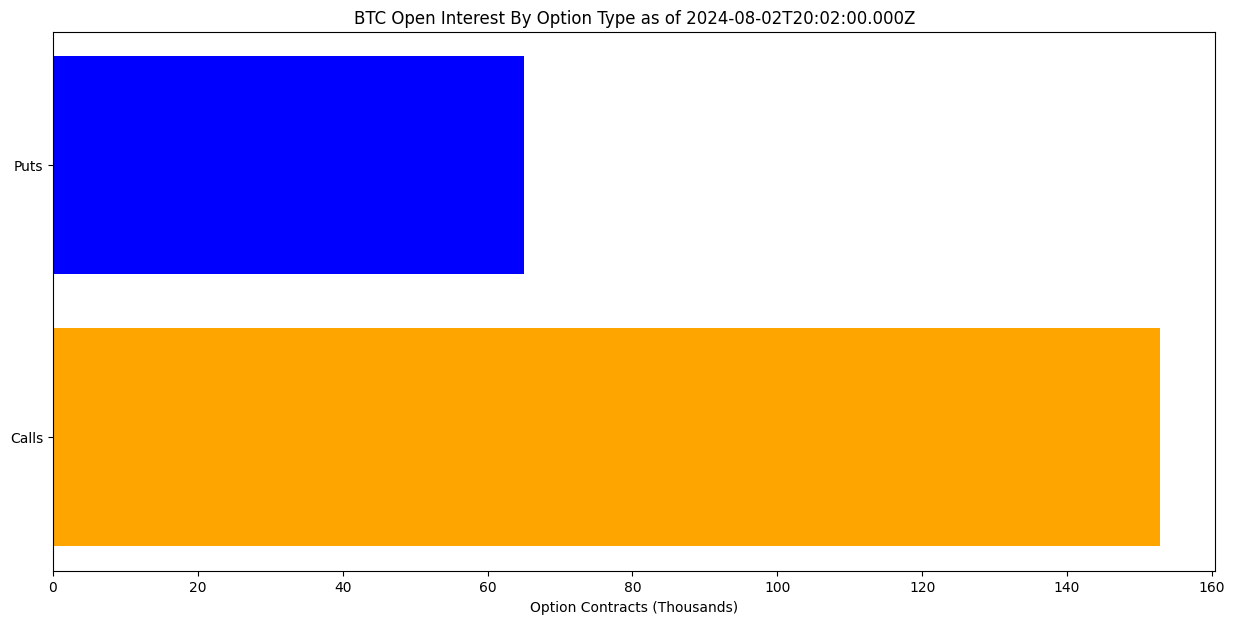

In [9]:
# plot OI for BTC option contracts
data = pd.DataFrame(amberdata_client.get_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])
oi = data.groupby("putCall").sum()

plt.figure(figsize=(15, 7))
plt.barh(['Calls'], oi['openInterest']['C']/1_000, color='orange')
plt.barh(['Puts'], oi['openInterest']['P']/1_000, color='blue')
plt.title("BTC Open Interest By Option Type as of " + str(data.timestamp[0]))
plt.xlabel("Option Contracts (Thousands)")

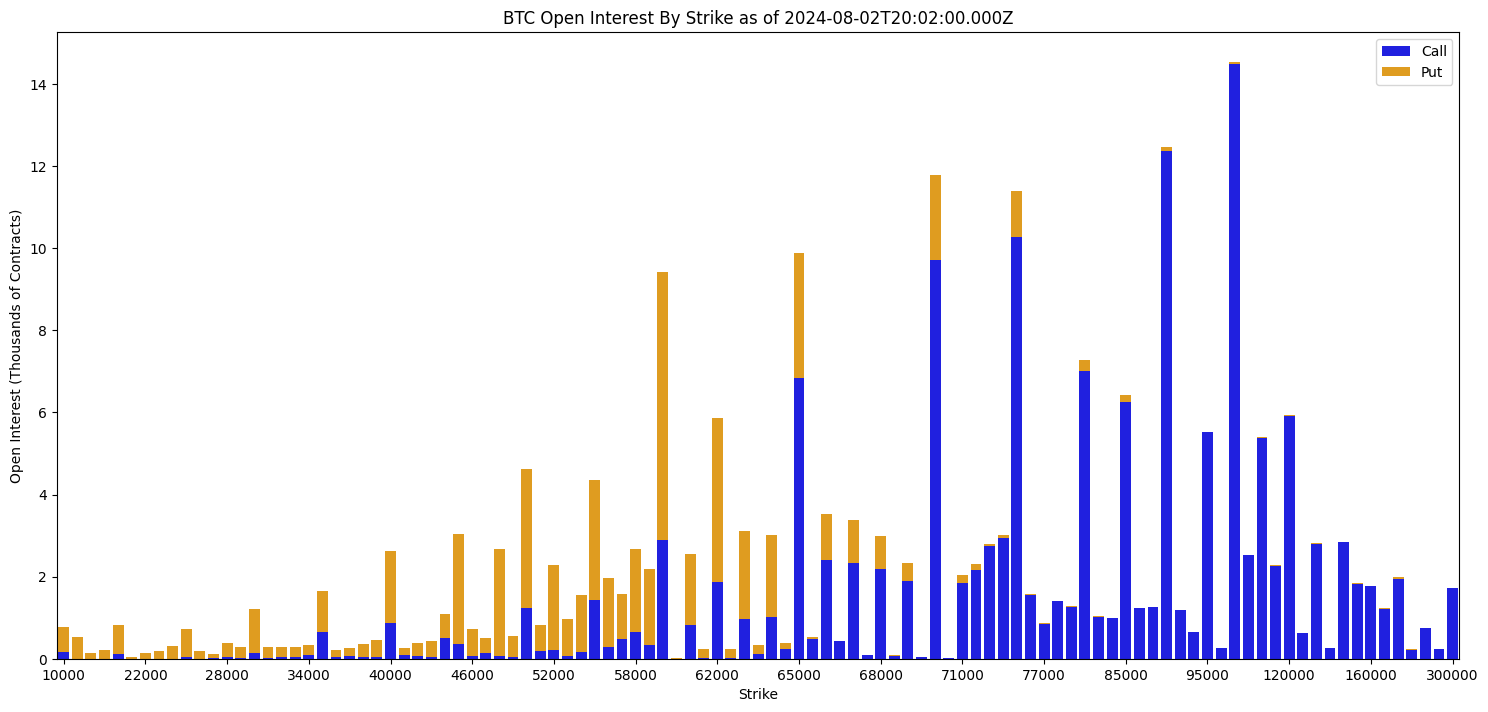

In [10]:
# plot distribution of BTC option OI across all strikes
data = pd.DataFrame(amberdata_client.get_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])

calls = data[data.putCall=='C']
puts = data[data.putCall=='P']

call_strike_oi = calls.groupby("strike").sum()[['openInterest']].reset_index()
put_strike_oi  =  puts.groupby("strike").sum()[['openInterest']].reset_index()

plt.figure(figsize=(15, 7))
sns.barplot(x=call_strike_oi.strike, y=call_strike_oi.openInterest/1000, color='blue', label='Call')
sns.barplot(x=put_strike_oi.strike, y=put_strike_oi.openInterest/1000, color='orange', 
            bottom=call_strike_oi.openInterest/1000, label='Put')

plt.tight_layout()
plt.gca().xaxis.set_major_locator(MaxNLocator(20))
plt.legend()
plt.title("BTC Open Interest By Strike as of " + str(data.timestamp[0]))
plt.ylabel("Open Interest (Thousands of Contracts)")
plt.xlabel("Strike");

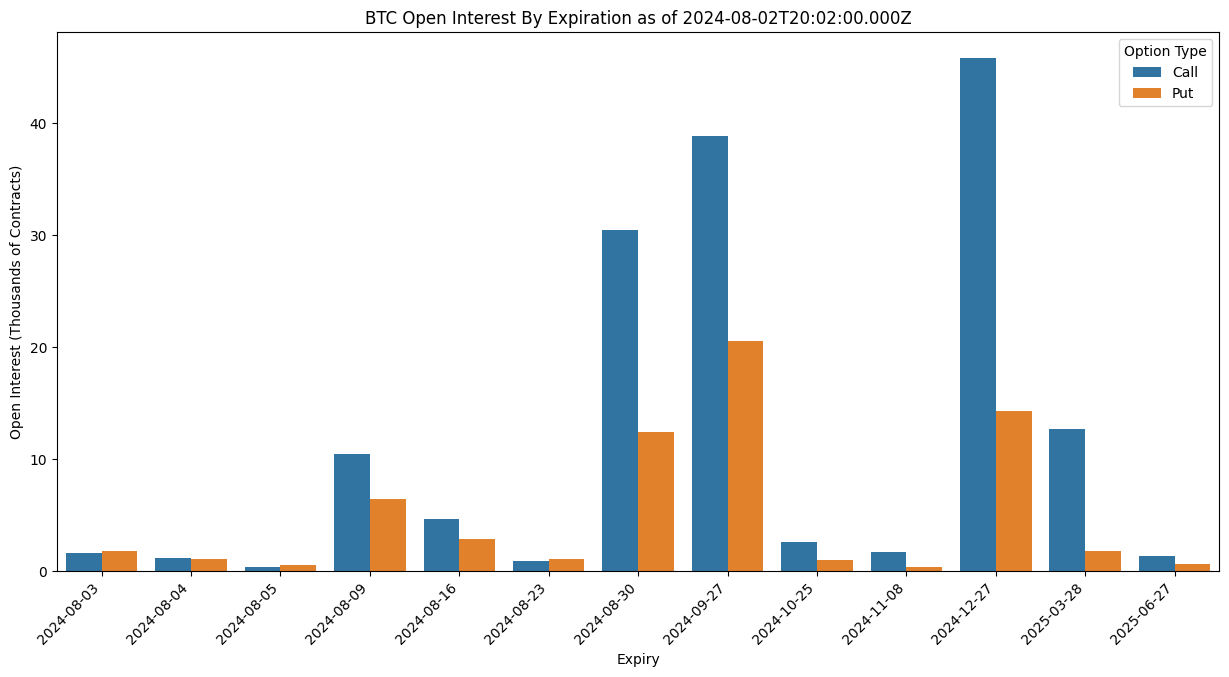

In [11]:
# plot distribution of BTC option OI across all maturities
data = pd.DataFrame(amberdata_client.get_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])

calls = data[data.putCall=='C']
puts = data[data.putCall=='P']

calls['expirationTimestamp'] = pd.to_datetime(calls.expirationTimestamp).dt.date
puts['expirationTimestamp']  =  pd.to_datetime(puts.expirationTimestamp).dt.date

c = calls.groupby("expirationTimestamp").sum().reset_index()
p = puts.groupby("expirationTimestamp").sum().reset_index()

c['openInterest'] /= 1000
p['openInterest'] /= 1000

c['op_type'] = 'Call'
p['op_type'] = 'Put'
t = pd.concat([c, p]).reset_index(drop=True)

# Create the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(data=t, x='expirationTimestamp', y='openInterest', hue='op_type')
plt.xticks(rotation=45, ha='right');
plt.title("BTC Open Interest By Expiration as of " + str(data.timestamp[0]))
plt.ylabel("Open Interest (Thousands of Contracts)")
plt.xlabel("Expiry")
plt.legend(title='Option Type')

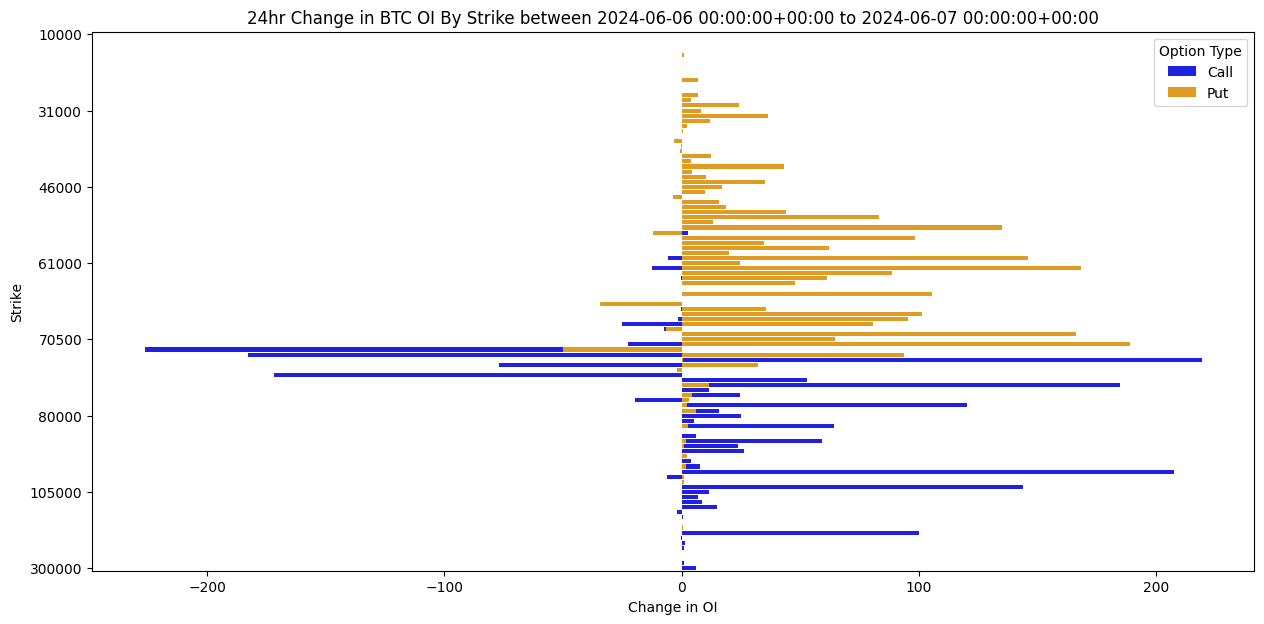

In [12]:
# plot 24 hour change in OI 
data = pd.DataFrame(amberdata_client.get_level_1_quotes(exchange='deribit', currency='btc', startDate='2024-06-05', endDate='2024-06-08', timeInterval='day')['payload']['data'])                                                     
data['timestamp'] = pd.to_datetime(data.timestamp)

yday = data[data.timestamp == '2024-06-06 00:00:00+00:00']
tday = data[data.timestamp == '2024-06-07 00:00:00+00:00']

tday_c = tday[tday.putCall=='C'].groupby("strike")[['openInterest']].sum()
tday_p = tday[tday.putCall=='P'].groupby("strike")[['openInterest']].sum()

yday_c = yday[yday.putCall=='C'].groupby("strike")[['openInterest']].sum()
yday_p = yday[yday.putCall=='P'].groupby("strike")[['openInterest']].sum()

call = pd.concat([tday_c, yday_c], axis=1)
call.columns = ['today', 'yesterday']
call['diffs'] = call.today - call.yesterday

put = pd.concat([tday_p, yday_p], axis=1)
put.columns = ['today', 'yesterday']
put['diffs'] = put.today - put.yesterday

call = call.reset_index()
put  = put.reset_index()

plt.figure(figsize=(15, 7))
sns.barplot(x=call.diffs, y=call.strike,  orient = 'h', color='blue', label='Call')
sns.barplot(x=put.diffs, y=put.strike,  orient = 'h', color='orange', label='Put')
plt.gca().yaxis.set_major_locator(MaxNLocator(10))

plt.title("24hr Change in BTC OI By Strike between " + str(yday.timestamp.iloc[0]) + " to " + str(tday.timestamp.iloc[0]))
plt.ylabel("Strike")
plt.xlabel("Change in OI")
plt.legend(title='Option Type')

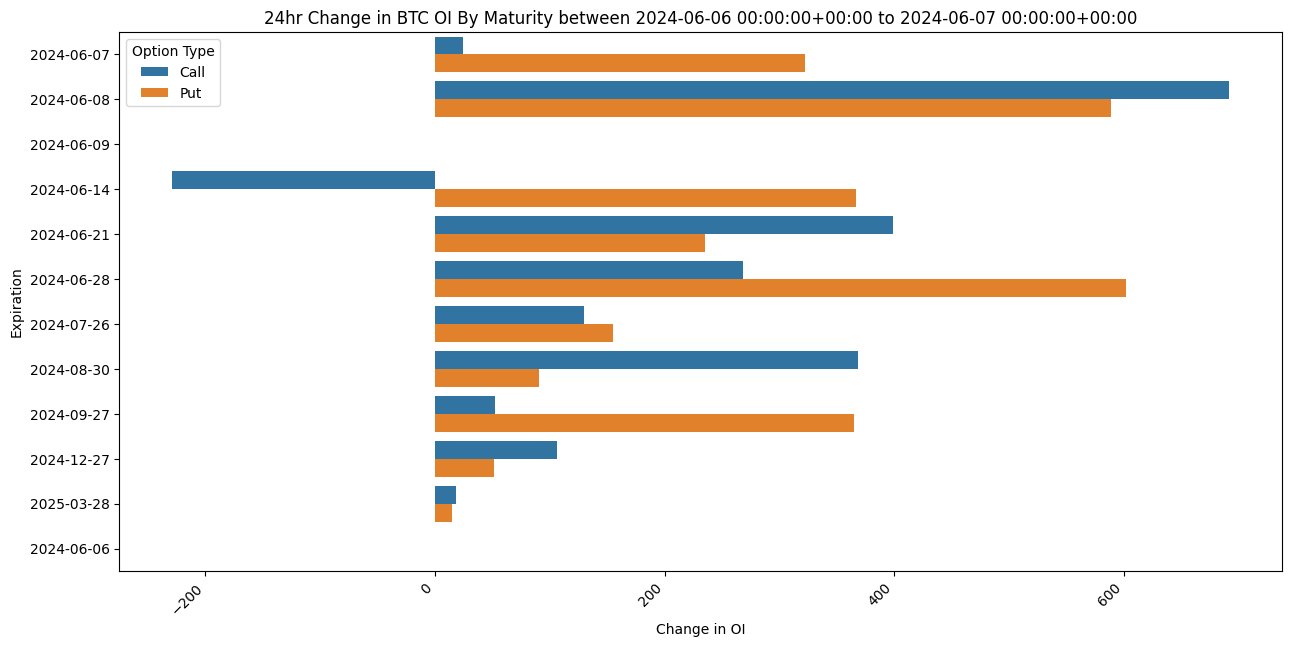

In [13]:
# plot 24 hour change in OI based on maturity
data = pd.DataFrame(amberdata_client.get_level_1_quotes(exchange='deribit', currency='btc', startDate='2024-06-05', endDate='2024-06-08', timeInterval='day')['payload']['data'])                                                     
data['timestamp'] = pd.to_datetime(data.timestamp)

yday = data[data.timestamp == '2024-06-06 00:00:00+00:00']
tday = data[data.timestamp == '2024-06-07 00:00:00+00:00']

tday_c = tday[tday.putCall=='C'].groupby("expirationTimestamp")[['openInterest']].sum()
tday_p = tday[tday.putCall=='P'].groupby("expirationTimestamp")[['openInterest']].sum()

yday_c = yday[yday.putCall=='C'].groupby("expirationTimestamp")[['openInterest']].sum()
yday_p = yday[yday.putCall=='P'].groupby("expirationTimestamp")[['openInterest']].sum()

calls = pd.concat([tday_c, yday_c], axis=1)
calls.columns = ['today', 'yesterday']
calls['diffs'] = calls.today - calls.yesterday

puts = pd.concat([tday_p, yday_p], axis=1)
puts.columns = ['today', 'yesterday']
puts['diffs'] = puts.today - puts.yesterday

calls['Option Type'] = 'Call'
puts['Option Type'] = 'Put'

t = pd.concat([calls, puts], axis=0).reset_index()
t['expirationTimestamp'] = pd.to_datetime(t.expirationTimestamp).dt.date

plt.figure(figsize=(15, 7))
sns.barplot(data=t, x='diffs', y='expirationTimestamp', hue='Option Type', orient='h')

plt.xticks(rotation=45, ha='right');
plt.title("24hr Change in BTC OI By Maturity between " + str(yday.timestamp.iloc[0]) + " to " + str(tday.timestamp.iloc[0]))
plt.ylabel("Expiration")
plt.xlabel("Change in OI")
plt.legend(title='Option Type')

In [12]:
# use this endpoint to get back all of the available instruments on deribit
amberdata_client.get_instruments_information(exchange='deribit')

{'status': 200,
 'title': 'OK',
 'description': 'Successful request',
 'payload': {'data': [{'exchange': 'deribit',
    'currency': 'BTC',
    'nativeInstrument': 'BTC-12JUL24-46000-C',
    'endDate': 1720716840000,
    'instrument': 'DERIBIT-BTC-12JUL24-46000.0-C',
    'multiplier': 1,
    'putCall': 'C',
    'expiration': 1720771200000,
    'strike': 46000},
   {'exchange': 'deribit',
    'currency': 'BTC',
    'nativeInstrument': 'BTC-12JUL24-46000-P',
    'endDate': 1720716840000,
    'instrument': 'DERIBIT-BTC-12JUL24-46000.0-P',
    'multiplier': 1,
    'putCall': 'P',
    'expiration': 1720771200000,
    'strike': 46000},
   {'exchange': 'deribit',
    'currency': 'BTC',
    'nativeInstrument': 'BTC-12JUL24-48000-C',
    'endDate': 1720716840000,
    'instrument': 'DERIBIT-BTC-12JUL24-48000.0-C',
    'multiplier': 1,
    'putCall': 'C',
    'expiration': 1720771200000,
    'strike': 48000},
   {'exchange': 'deribit',
    'currency': 'BTC',
    'nativeInstrument': 'BTC-12JUL24-48

Text(0, 0.5, 'Rolling Correlation')

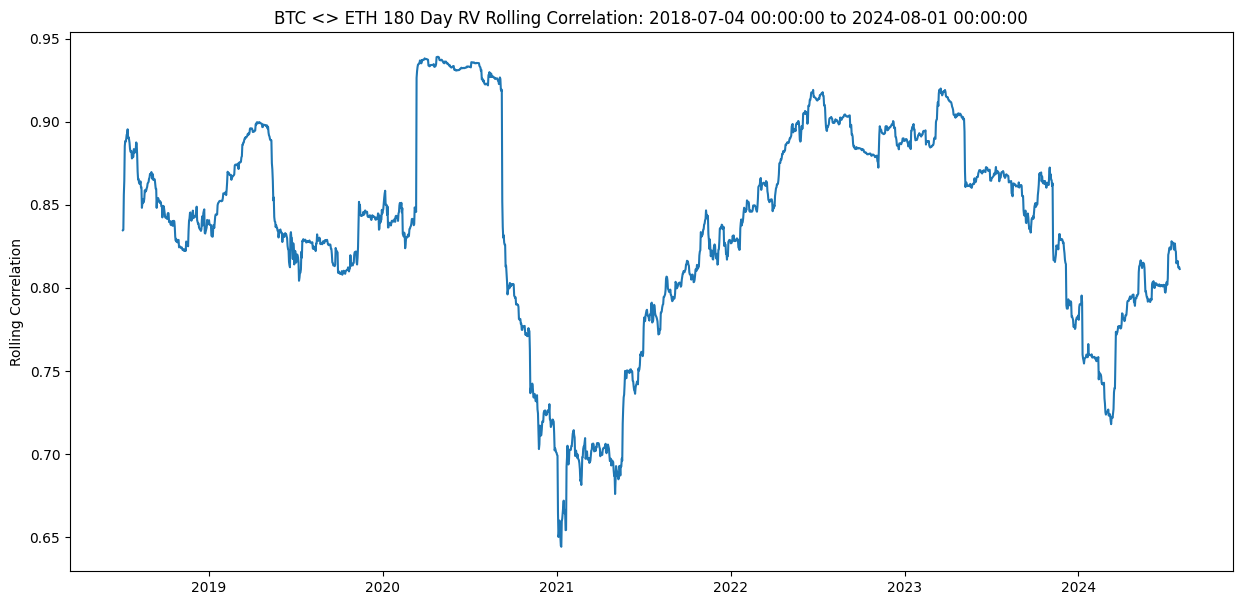

In [14]:
# Plot BTC <> ETH correlation of log daily returns 
data = amberdata_client.get_realized_volatility_correlation_beta(exchange='gdax', pair='btc_usd', pair2='eth_usd')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp, unit='ms')
data = data[::-1]

plt.figure(figsize=(15, 7))
plt.plot(data.correlation180)
plt.title("BTC <> ETH 180 Day RV Rolling Correlation: " + str(data.index[0]) + " to " + str(data.iloc[-1].name))
plt.ylabel("Rolling Correlation")

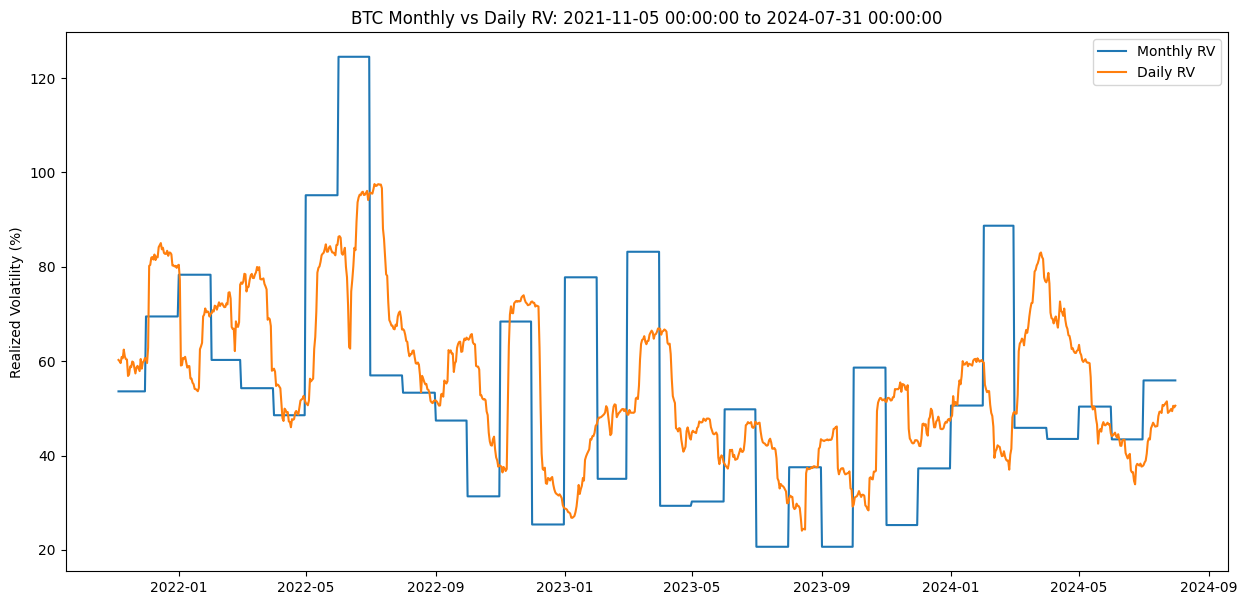

In [15]:
# Plot BTC Monthly vs Daily Realized Volatility 
data = amberdata_client.get_realized_volatility_monthly_vs_daily_ratio(exchange='gdax', pair='btc_usd')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp, unit='ms')

# only look at a subset of data
data = data[:1000][::-1]
plt.figure(figsize=(15, 7))
plt.title("BTC Monthly vs Daily RV: " + str(data.index[0]) + " to " + str(data.iloc[-1].name))
plt.plot(data.monthlyHistoricalVolatility, label='Monthly RV')
plt.plot(data.dailyHistoricalVolatility30Days, label='Daily RV')
plt.ylabel("Realized Volatility (%)")
plt.legend();

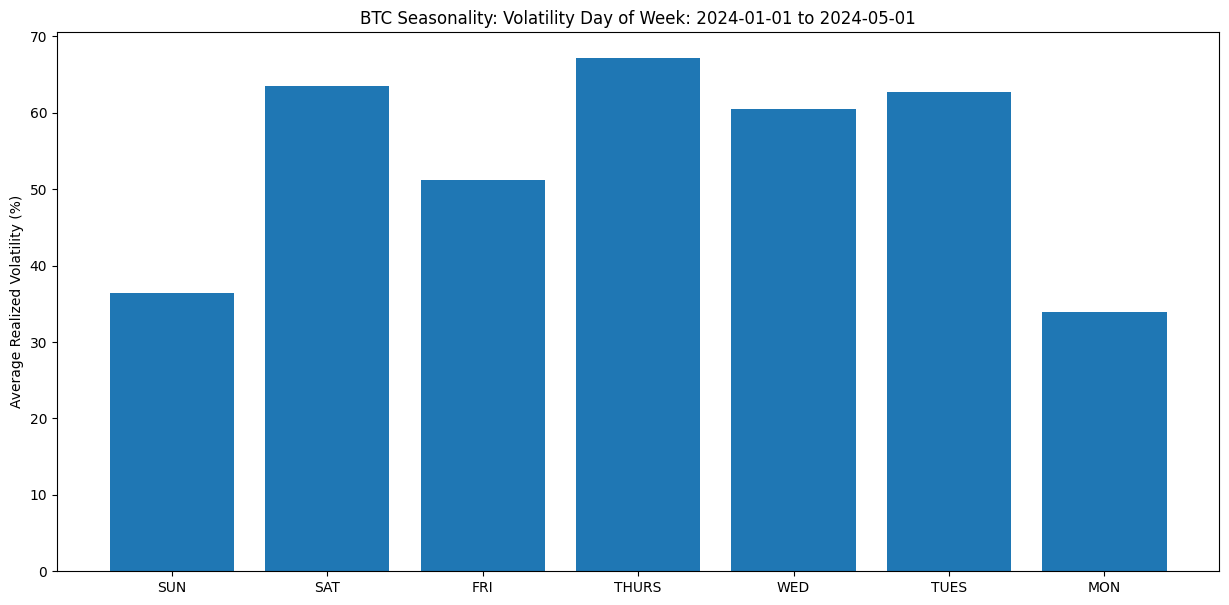

In [16]:
# plot BTC vol seasonality for day of week
data = amberdata_client.get_realized_volatility_seasonality_day_of_week(exchange='gdax', pair='btc_usd', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])
data = data[::-1]

plt.figure(figsize=(15, 7))
plt.bar(data.weekday, data.historicalVolatility1day)
plt.ylabel("Average Realized Volatility (%)")
plt.title("BTC Seasonality: Volatility Day of Week: 2024-01-01 to 2024-05-01");

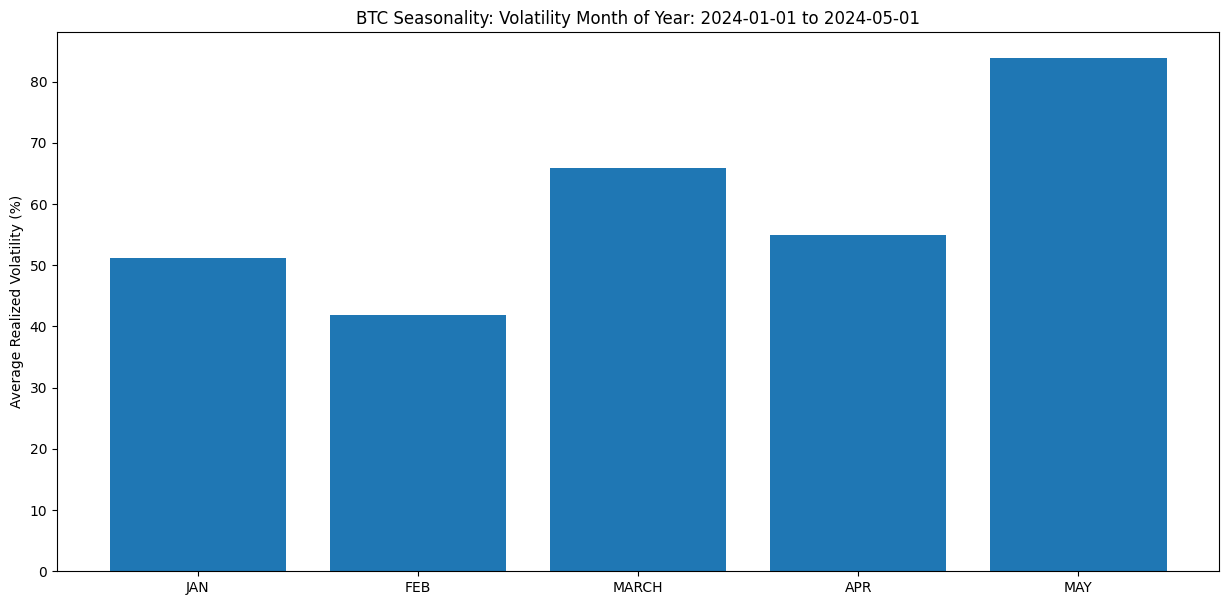

In [17]:
# plot BTC vol seasonality for month of year
data = amberdata_client.get_realized_volatility_seasonality_month_of_year(exchange='gdax', pair='btc_usd', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])

plt.figure(figsize=(15, 7))
plt.bar(data.month, data.historicalVolatility1day)
plt.ylabel("Average Realized Volatility (%)")
plt.title("BTC Seasonality: Volatility Month of Year: 2024-01-01 to 2024-05-01");

Text(0.5, 0, 'DTE')

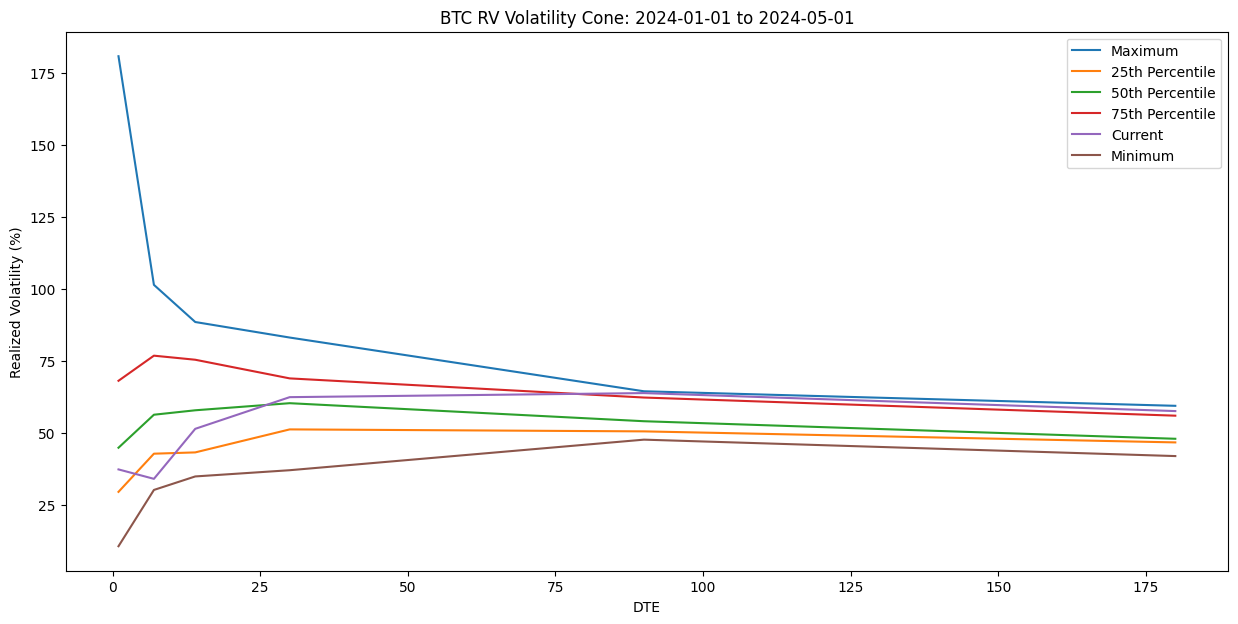

In [18]:
# plot realized volatility cones for BTC 
data = amberdata_client.get_realized_volatility_cones(exchange='gdax', pair='btc_usd', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])
data = data.iloc[:, 2:].T

data['dte'] = [
    int(''.join([char for char in column.split("_")[1] if char.isdigit()]))
    for column in data.index
]
data['vol_level'] = [data.index[i].split("_")[0] for i in range(len(data))]
data.columns = ['rv', 'dte', 'vol_level']

cone_max = data[data.vol_level=='max'].sort_values('dte', ascending=True)
cone_min = data[data.vol_level=='min'].sort_values('dte', ascending=True)
cone_25p = data[data.vol_level=='p25'].sort_values('dte', ascending=True)
cone_50p = data[data.vol_level=='p50'].sort_values('dte', ascending=True)
cone_75p = data[data.vol_level=='p75'].sort_values('dte', ascending=True)
cone_current = data[data.vol_level=='current'].sort_values('dte', ascending=True)

plt.figure(figsize=(15, 7))
plt.plot(cone_max.dte, cone_max.rv, label='Maximum')
plt.plot(cone_25p.dte, cone_25p.rv, label='25th Percentile')
plt.plot(cone_50p.dte, cone_50p.rv, label='50th Percentile')
plt.plot(cone_75p.dte, cone_75p.rv, label='75th Percentile')
plt.plot(cone_current.dte, cone_current.rv, label='Current')
plt.plot(cone_min.dte, cone_min.rv, label='Minimum')

plt.legend()
plt.title("BTC RV Volatility Cone: 2024-01-01 to 2024-05-01")
plt.ylabel("Realized Volatility (%)")
plt.xlabel("DTE")

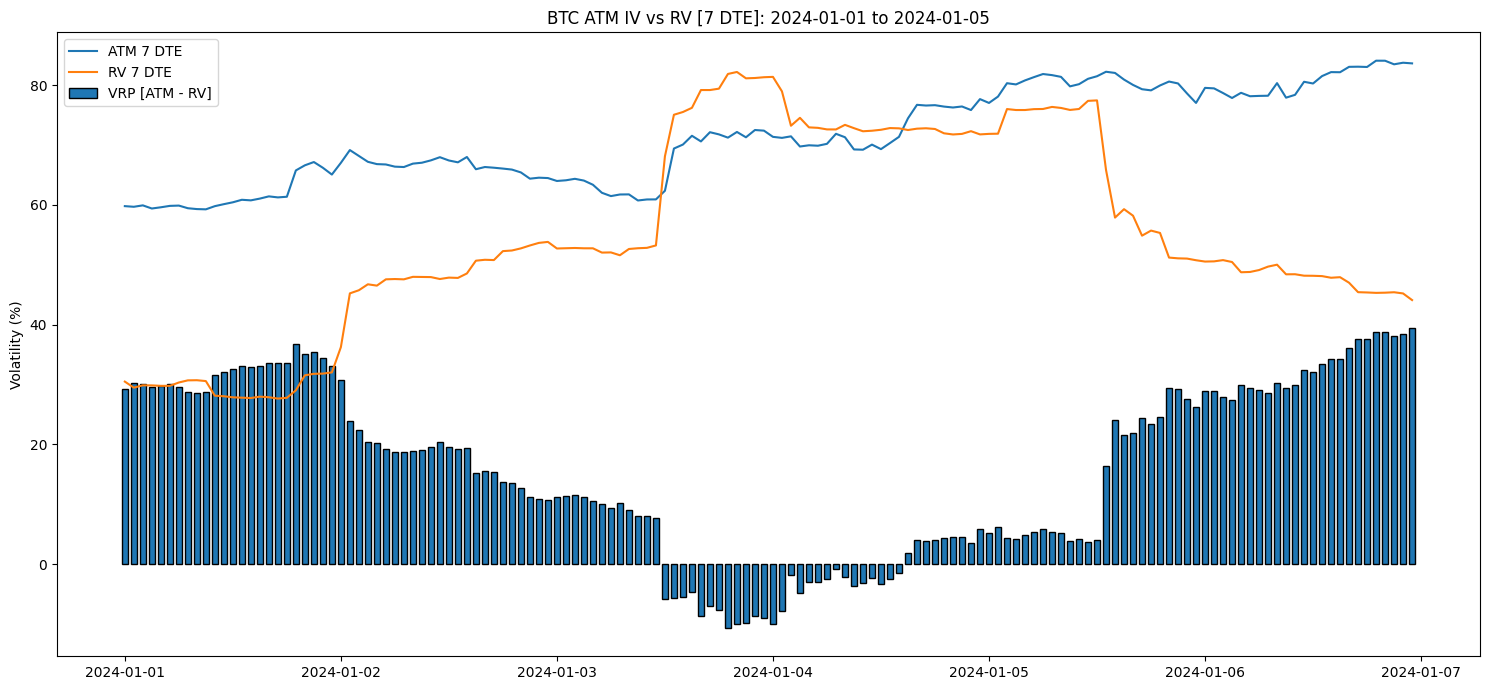

In [20]:
# plot IV vs RV + VRP 
data = amberdata_client.get_realized_volatility_implied_vs_realized(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-01-07')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp, unit='ms')
data['vrp'] = data.atm7 - data.realizedVolatility7

plt.figure(figsize=(15, 7))
plt.title("BTC ATM IV vs RV [7 DTE]: 2024-01-01 to 2024-01-05")
plt.bar(data.index, data.vrp, label='VRP [ATM - RV]', edgecolor='black', width=0.03)
plt.plot(data.index, data.atm7, label='ATM 7 DTE')
plt.plot(data.index, data.realizedVolatility7, label='RV 7 DTE')

plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()

In [40]:
data['vrp']

timestamp
2024-01-04 23:00:00     5.893934
2024-01-04 22:00:00     3.529375
2024-01-04 21:00:00     4.578208
2024-01-04 20:00:00     4.504243
2024-01-04 19:00:00     4.462078
                         ...    
2024-01-01 04:00:00    29.820006
2024-01-01 03:00:00    29.541064
2024-01-01 02:00:00    30.051612
2024-01-01 01:00:00    30.208324
2024-01-01 00:00:00    29.302213
Name: vrp, Length: 96, dtype: float64

Text(0, 0.5, 'Term Structure Richness Ratio')

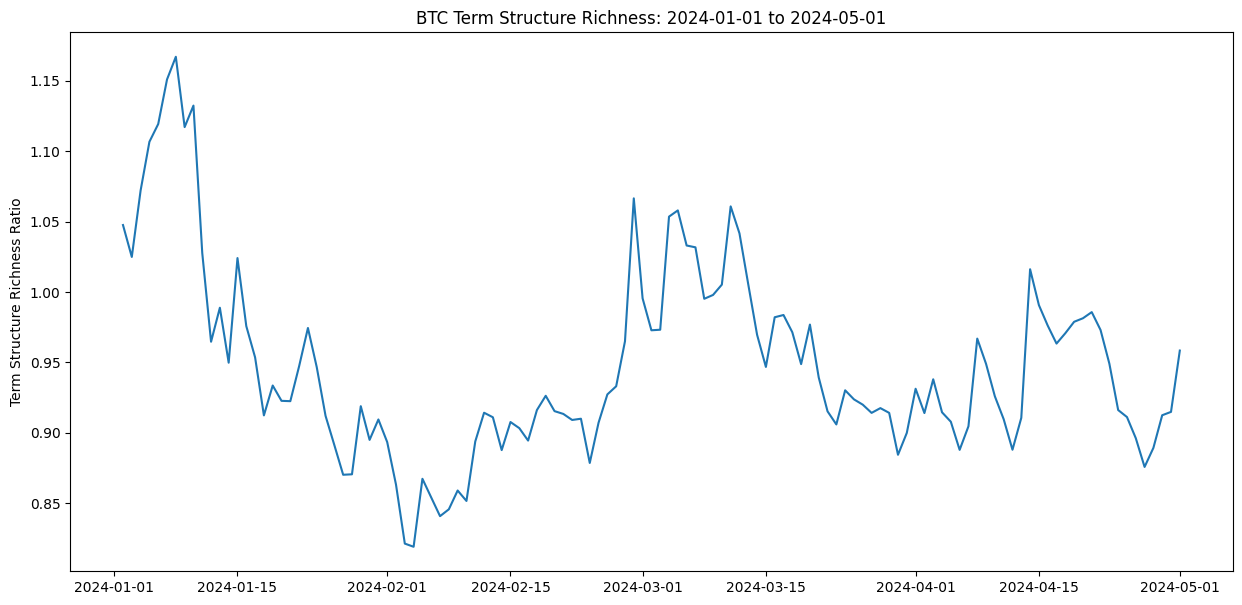

In [21]:
data = amberdata_client.get_volatility_term_structures_richness(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp)

plt.figure(figsize=(15, 7))
plt.plot(data.richness)
plt.title("BTC Term Structure Richness: 2024-01-01 to 2024-05-01")
plt.ylabel("Term Structure Richness Ratio")

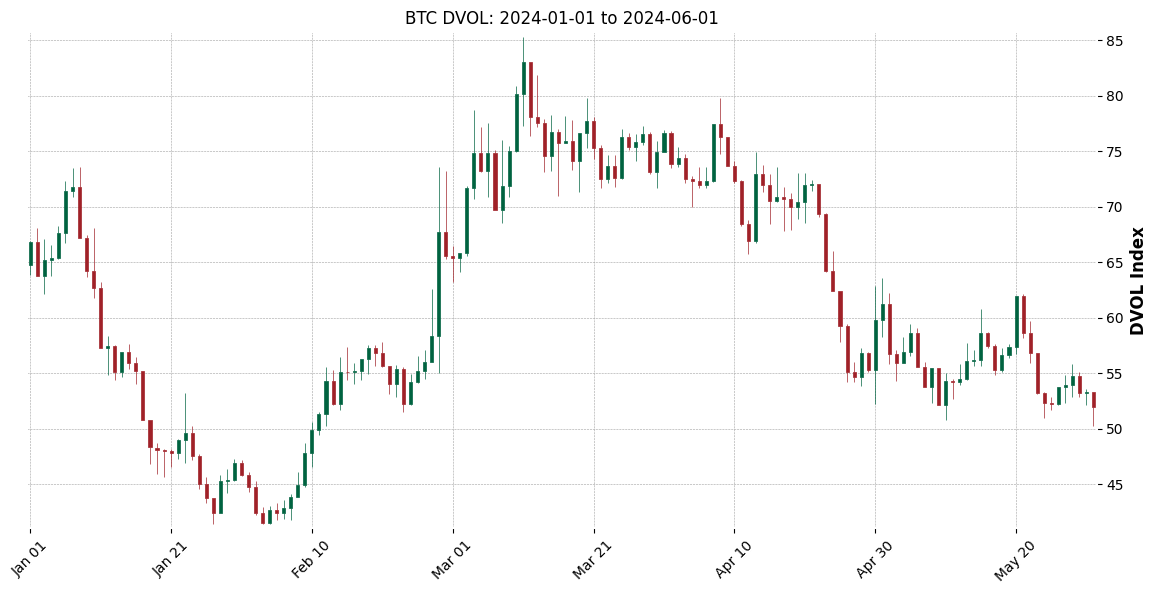

In [26]:
# plot BTC DVOL 
dvol = amberdata_client.get_volatility_index(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-06-01', timeInterval='day')
dvol = pd.DataFrame(dvol['payload']['data'])
dvol.index = pd.to_datetime(dvol.exchangeTimestamp, unit='ms')
dvol = dvol[dvol.currency=='BTC']
dvol = dvol.sort_index()

mpf.plot(dvol, type='candle', style='charles', figratio=(15, 7), 
         ylabel='DVOL Index', axtitle='BTC DVOL: 2024-01-01 to 2024-06-01', tight_layout=True)

Text(0, 0.5, 'ATM IV')

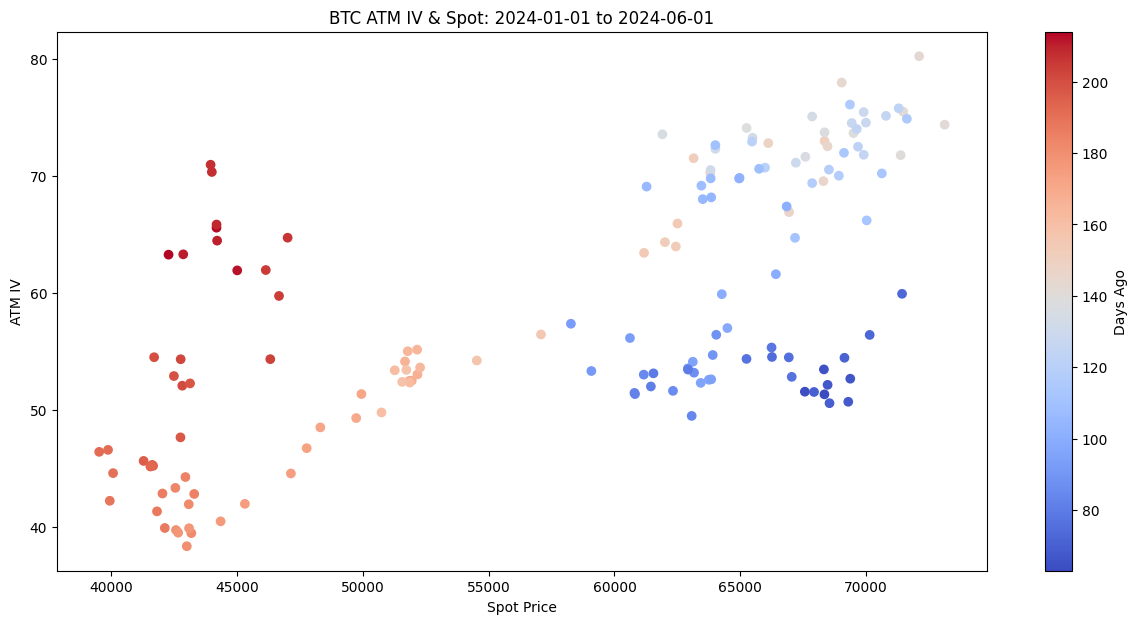

In [22]:
# plot DVOL vs spot and RR vs spot
data = amberdata_client.get_volatility_index_decorated(exchange='deribit', currency='btc',  startDate='2024-01-01', endDate='2024-06-01', timeInterval='day')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.exchangeTimestamp, unit='ms')
data = data[data.currency=='BTC']
data = data.sort_index()

plt.figure(figsize=(15, 7))
scatter = plt.scatter(data.indexPrice, data.atm, c=data.daysAgo, cmap='coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Days Ago')
plt.title("BTC ATM IV & Spot: 2024-01-01 to 2024-06-01")
plt.xlabel("Spot Price")
plt.ylabel("ATM IV")

Text(0, 0.5, '25 RR Skew')

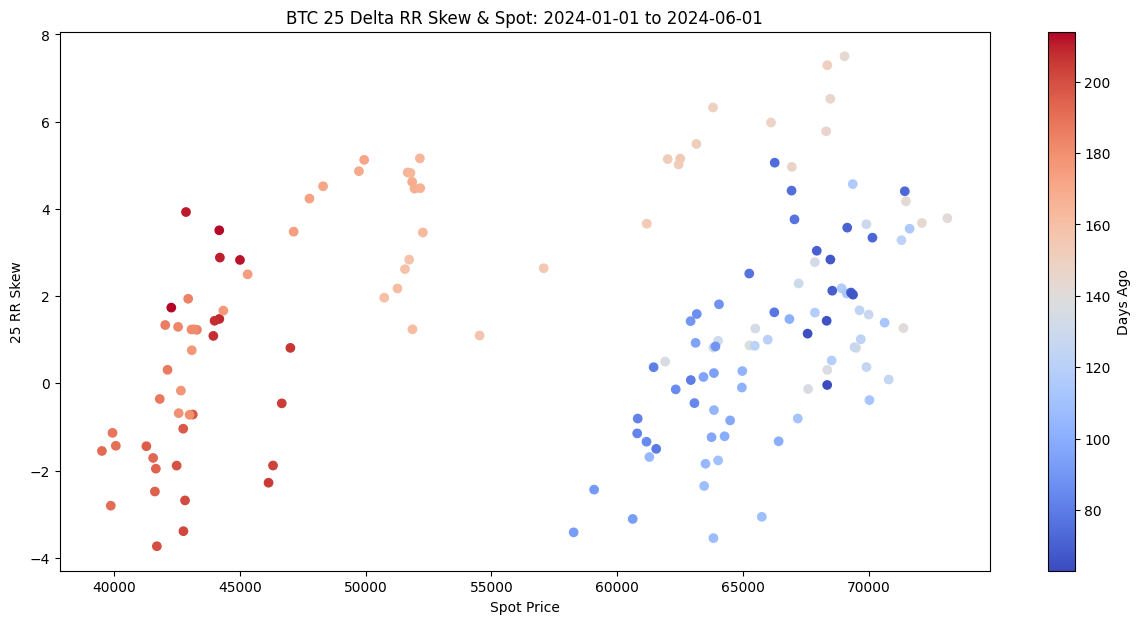

In [23]:
plt.figure(figsize=(15, 7))
scatter = plt.scatter(data.indexPrice, data.delta25RrSkew, c=data.daysAgo, cmap='coolwarm')
cbar = plt.colorbar(scatter)
cbar.set_label('Days Ago')
plt.title("BTC 25 Delta RR Skew & Spot: 2024-01-01 to 2024-06-01")
plt.xlabel("Spot Price")
plt.ylabel("25 RR Skew")

Text(0, 0.5, 'Butterfly Ratio')

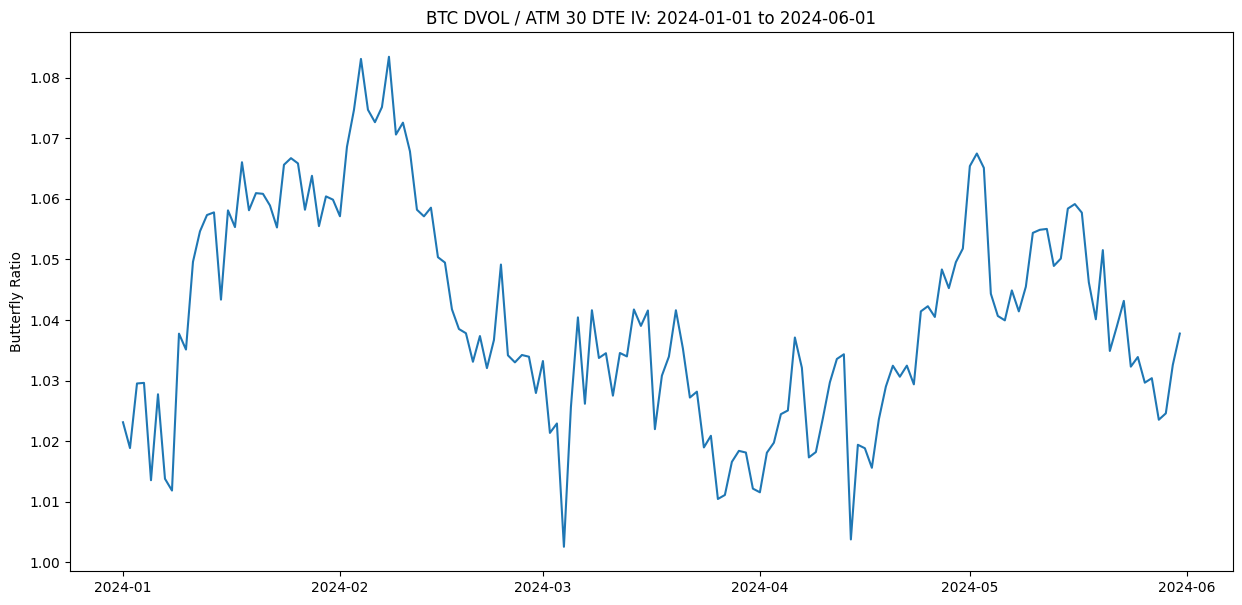

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(data.close/data.atm)
plt.title("BTC DVOL / ATM 30 DTE IV: 2024-01-01 to 2024-06-01")
plt.ylabel("Butterfly Ratio")

In [25]:
# get vol metrics table
data = amberdata_client.get_volatility_metrics(exchange='deribit', currency='btc', daysBack=7)
data = pd.DataFrame(data['payload']['data'])
data

,exchange,currency,expirationTimestamp,daysToExpiration,underlyingPrice,underlyingPriceChange,riskReversal25,riskReversal25Change,riskReversal15,riskReversal15Change,butterfly25,butterfly25Change,butterfly15,butterfly15Change,atm,atmChange
0,deribit,BTC,1723190400000,6.497917,63018.387903,-5166.607742,-3.470679,-9.048046,-5.550462,-14.549199,4.222000,0.552122,10.231839,2.674004,45.874039,-16.389705
1,deribit,BTC,1723795200000,13.497917,63109.433281,-5254.522336,-1.978413,-6.849698,-2.991982,-10.413047,3.269137,0.343903,8.330645,1.532990,46.375653,-13.342215
2,deribit,BTC,1725004800000,27.497917,63282.830481,-5378.532692,-0.875901,-5.382796,-1.419892,-8.196504,2.994257,-0.047793,7.652291,0.808260,47.117729,-11.057474
3,deribit,BTC,1727424000000,55.497917,63702.827431,-5480.332185,0.447570,-4.095543,0.549668,-6.897728,3.043310,-0.223605,7.688403,0.959138,49.703041,-9.445057
4,deribit,BTC,1729843200000,83.497917,64182.448533,-5609.106249,1.633152,-2.414417,2.229495,-4.346377,2.580538,-0.344553,6.257337,0.655682,51.676361,-8.884878
5,deribit,BTC,1731052800000,97.497917,64424.497807,-5670.986890,1.927729,-3.060198,3.505325,-4.111521,3.026715,-0.407644,6.234442,-1.060700,53.835692,-8.353932
6,deribit,BTC,1735286400000,146.497917,65274.739274,-5885.471774,2.767228,-2.159365,4.065297,-3.424776,2.862998,-0.374847,6.182213,-0.134145,56.240315,-7.724059
7,deribit,BTC,1743148800000,237.497917,66995.329600,-6174.658000,3.426177,-2.333448,4.935541,-3.706749,2.891383,-1.154106,5.746350,-1.214436,58.091812,-7.427478
8,deribit,BTC,1751011200000,328.497917,68535.417917,-6427.247311,4.873437,-1.697319,6.833748,-2.331779,3.607195,-0.676828,6.240721,-0.638072,59.123438,-7.229929


Text(0.5, 1.0, 'BTC Put Call Trade Distribution Over the Past 7 Days')

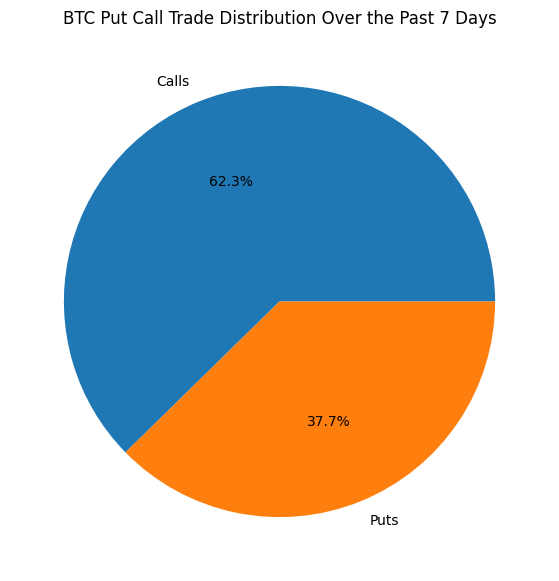

In [26]:
# plot put/call trade distribution
data = amberdata_client.get_trades_flow_block_volumes(exchange='deribit', currency='btc')
data = pd.DataFrame(data['payload']['data'])
data = data.groupby("putCall").sum()

plt.figure(figsize=(15, 7))
labels = ['Calls', 'Puts']
plt.pie(data.contractVolume.values.flatten(), labels=labels, autopct='%1.1f%%')
plt.title("BTC Put Call Trade Distribution Over the Past 7 Days")

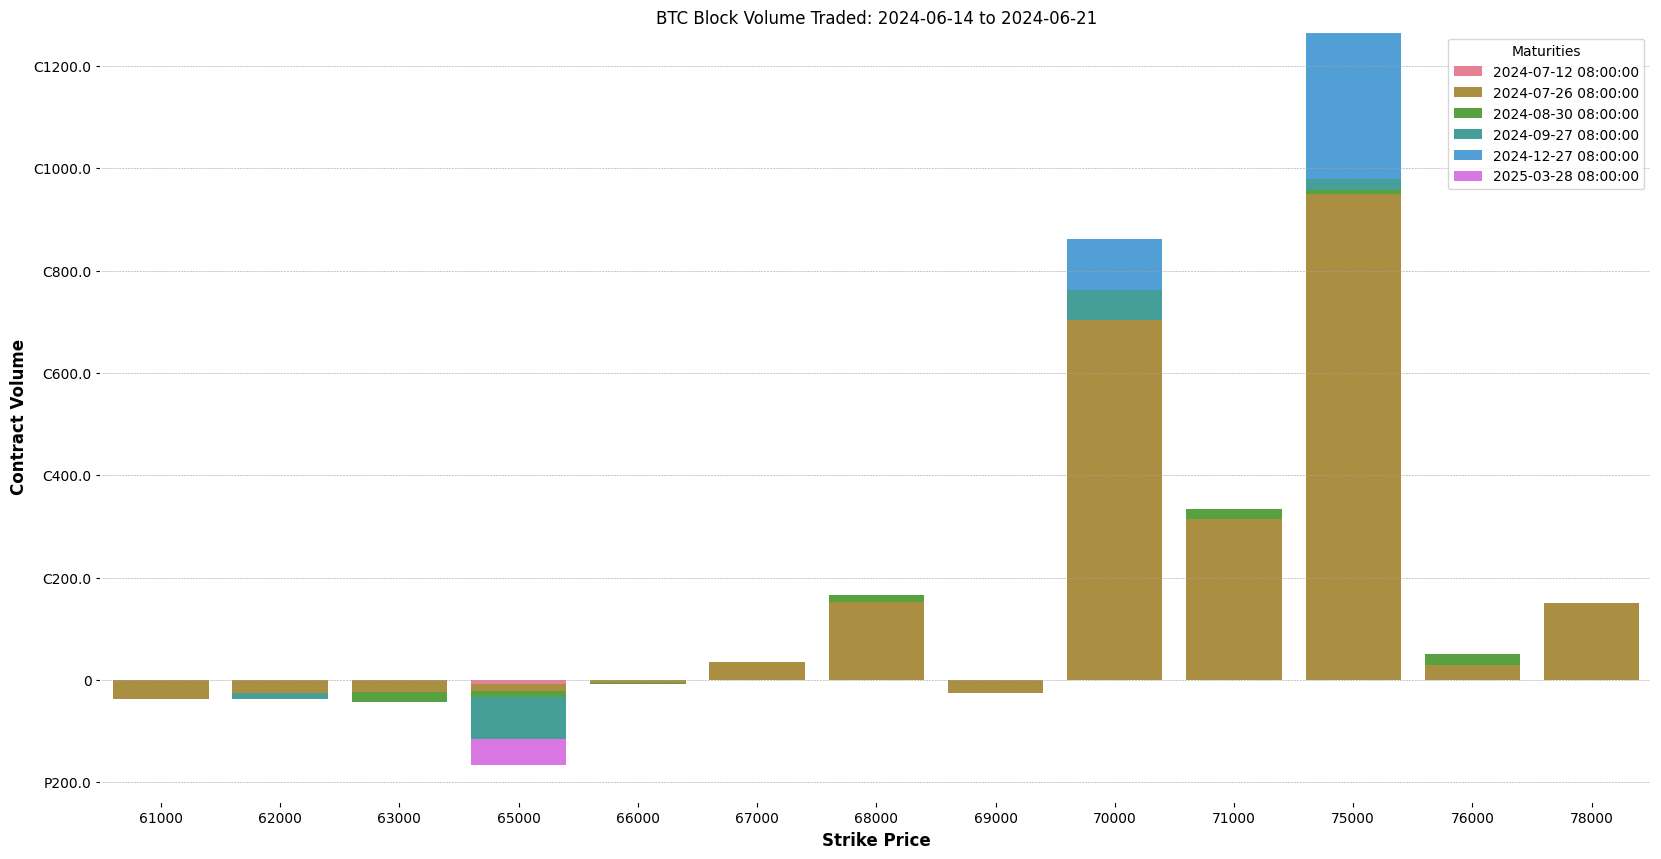

In [32]:
# plot block trade bar plot
data = amberdata_client.get_trades_flow_block_volumes(exchange='deribit', currency='btc', startDate='2024-06-14', endDate='2024-06-21')
data = pd.DataFrame(data['payload']['data'])

data['expirationTimestamp'] = pd.to_datetime(data.expirationTimestamp, unit='ms')
data['adj_volume'] = np.where(data.putCall=='P', -data.contractVolume, data.contractVolume)
# only look at expiries that are valid today 
data = data[data.expirationTimestamp >= pd.to_datetime(time.time(), unit='s')]

exps = set(data.expirationTimestamp)
store = []
for exp in exps:
    sub = data[data.expirationTimestamp == exp].reset_index(drop=True)    
    sub = sub[['expirationTimestamp', 'strike', 'putCall', 'adj_volume']]
    # filter out strikes to allow for better visual plotting
    sub = sub[(sub.strike > 60_000) & (sub.strike < 80_000)]
    sub['maturity'] = exp
    store.append(sub)
    
combined_df = pd.concat(store)
pivot_df = combined_df.pivot_table(index='strike', columns='maturity', values='adj_volume', aggfunc='sum').fillna(0)    

fig, ax = plt.subplots(figsize=(20, 10))
# Define colors for each maturity
colors = sns.color_palette("husl", len(pivot_df.columns))
maturities = pivot_df.columns

# Stack the bars
bottom = pd.Series([0]*len(pivot_df), index=pivot_df.index)
for maturity, color in zip(maturities, colors):
    sns.barplot(x=pivot_df.index, y=pivot_df[maturity], bottom=bottom, label=maturity, color=color)
    bottom += pivot_df[maturity]

ax.legend(title='Maturities')    
ax.set_xlabel('Strike Price')
ax.set_ylabel('Contract Volume')
yticks = ax.get_yticks()
yticklabels = ['C' + str(y) if y > 0 else 'P' + str(-y) if y < 0 else '0' for y in yticks]
ax.set_yticklabels(yticklabels);
plt.title("BTC Block Volume Traded: 2024-06-14 to 2024-06-21");

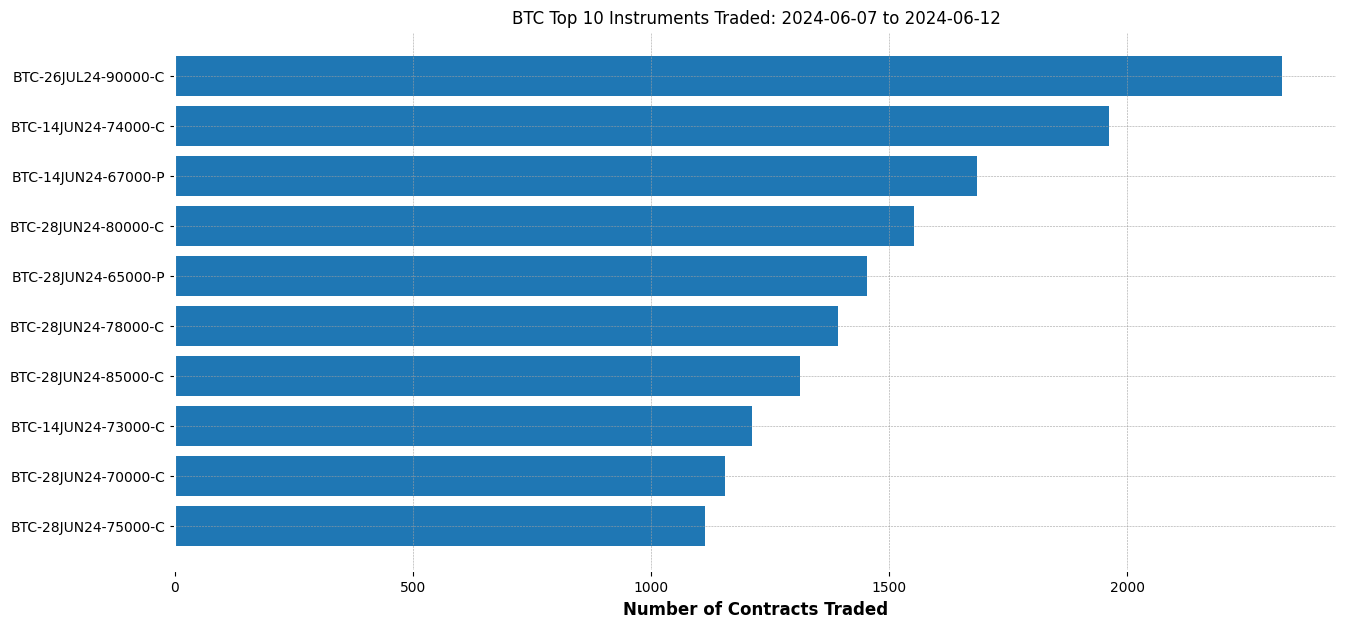

In [33]:
# plot top 10 instruments traded
data = amberdata_client.get_instruments_most_traded(exchange='deribit', currency='BTC', startDate='2024-06-07', endDate='2024-06-12')
data = pd.DataFrame(data['payload']['data'])

plt.figure(figsize=(15, 7))
plt.barh(data.instrument[:10], data.contractVolume[:10][::-1])
plt.title("BTC Top 10 Instruments Traded: 2024-06-07 to 2024-06-12")
plt.xlabel("Number of Contracts Traded");

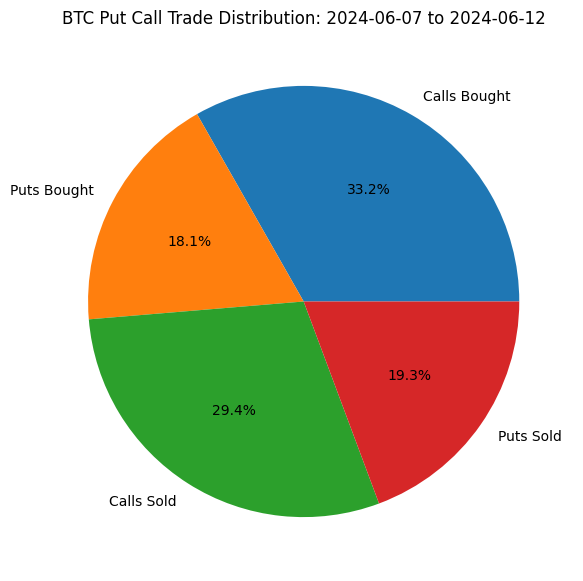

In [34]:
# plot trade distribution
data = amberdata_client.get_trades_flow_put_call_distribution(exchange='deribit', currency='BTC', startDate='2024-06-07', endDate='2024-06-12')
data = pd.DataFrame(data['payload']['data'])

plt.figure(figsize=(15, 7))
labels = ['Calls Bought', 'Puts Bought', 'Calls Sold', 'Puts Sold']
plt.pie(data.iloc[:, :4].values.flatten(), labels=labels, autopct='%1.1f%%')
plt.title("BTC Put Call Trade Distribution: 2024-06-07 to 2024-06-12");

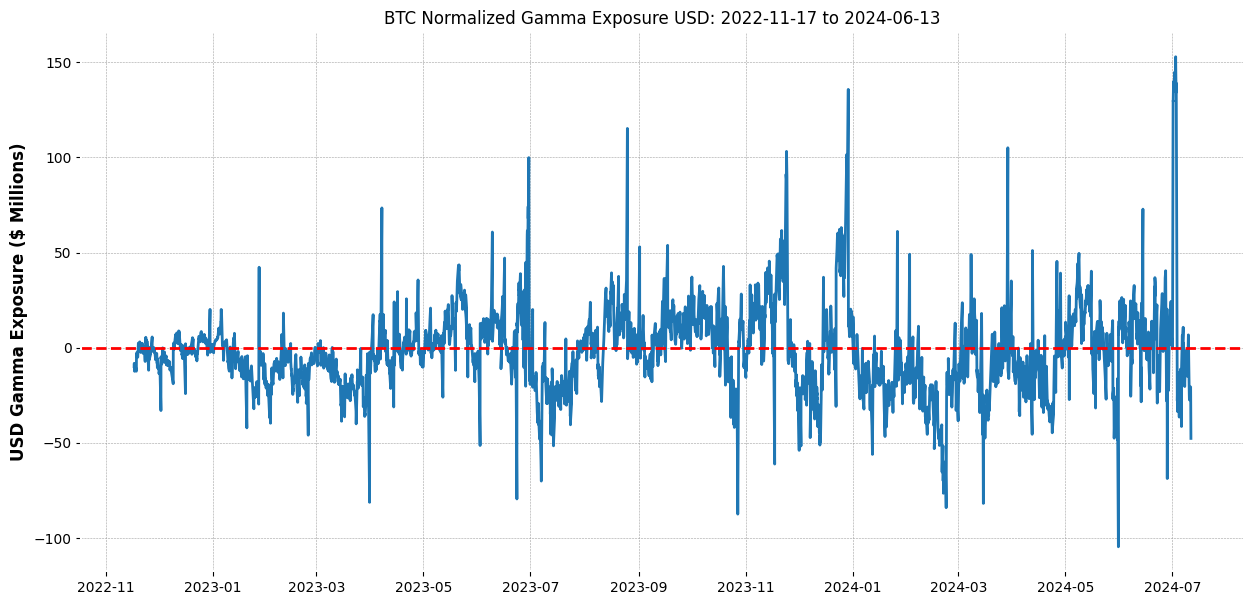

In [35]:
# plot normalized gamma USD
data = amberdata_client.get_trades_flow_gamma_exposures_normalized_usd(exchange='deribit', currency='btc')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.snapshotTimestamp, unit='ms')

plt.figure(figsize=(15, 7))
plt.plot(data.normalizedGammaUSD/1_000_000)
plt.axhline(0, linestyle='--', c='r')
plt.title("BTC Normalized Gamma Exposure USD: 2022-11-17 to 2024-06-13")
plt.ylabel("USD Gamma Exposure ($ Millions)");

In [36]:
# table of gex snapshots across different instruments
data = amberdata_client.get_trades_flow_gamma_exposures_snapshots(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-01-02')
data = pd.DataFrame(data['payload']['data'])
data

,exchange,currency,snapshotTimestamp,expirationTimestamp,instrumentNormalized,putCall,dealerNetInventory,dealerTotalInventory,gammaLevel,indexPrice,strike
0,deribit,BTC,1704150000000,1704182400000,DERIBIT-BTC-02JAN24-37000.0-P,P,-1.4,-2.0,-0.000020,42374.05,37000.0
1,deribit,BTC,1704150000000,1704182400000,DERIBIT-BTC-02JAN24-37500.0-P,P,-4.8,-28.4,-0.000284,42524.25,37500.0
2,deribit,BTC,1704150000000,1704182400000,DERIBIT-BTC-02JAN24-38000.0-P,P,-0.6,-14.2,-0.000284,42298.28,38000.0
3,deribit,BTC,1704150000000,1704182400000,DERIBIT-BTC-02JAN24-38500.0-P,P,12.5,14.9,0.000149,42444.56,38500.0
4,deribit,BTC,1704150000000,1704182400000,DERIBIT-BTC-02JAN24-39000.0-P,P,2.8,11.2,0.000224,42377.64,39000.0
...,...,...,...,...,...,...,...,...,...,...,...
18637,deribit,BTC,1704067200000,1711699200000,DERIBIT-BTC-29MAR24-80000.0-P,P,0.0,0.0,0.000000,30271.88,80000.0
18638,deribit,BTC,1704067200000,1711699200000,DERIBIT-BTC-29MAR24-85000.0-C,C,64.0,439.9,0.004399,42455.49,85000.0
18639,deribit,BTC,1704067200000,1711699200000,DERIBIT-BTC-29MAR24-85000.0-P,P,0.0,0.0,0.000000,43509.51,85000.0
18640,deribit,BTC,1704067200000,1711699200000,DERIBIT-BTC-29MAR24-90000.0-C,C,53.4,321.5,0.003215,41785.66,90000.0


Text(0.5, 0, 'Size Vega')

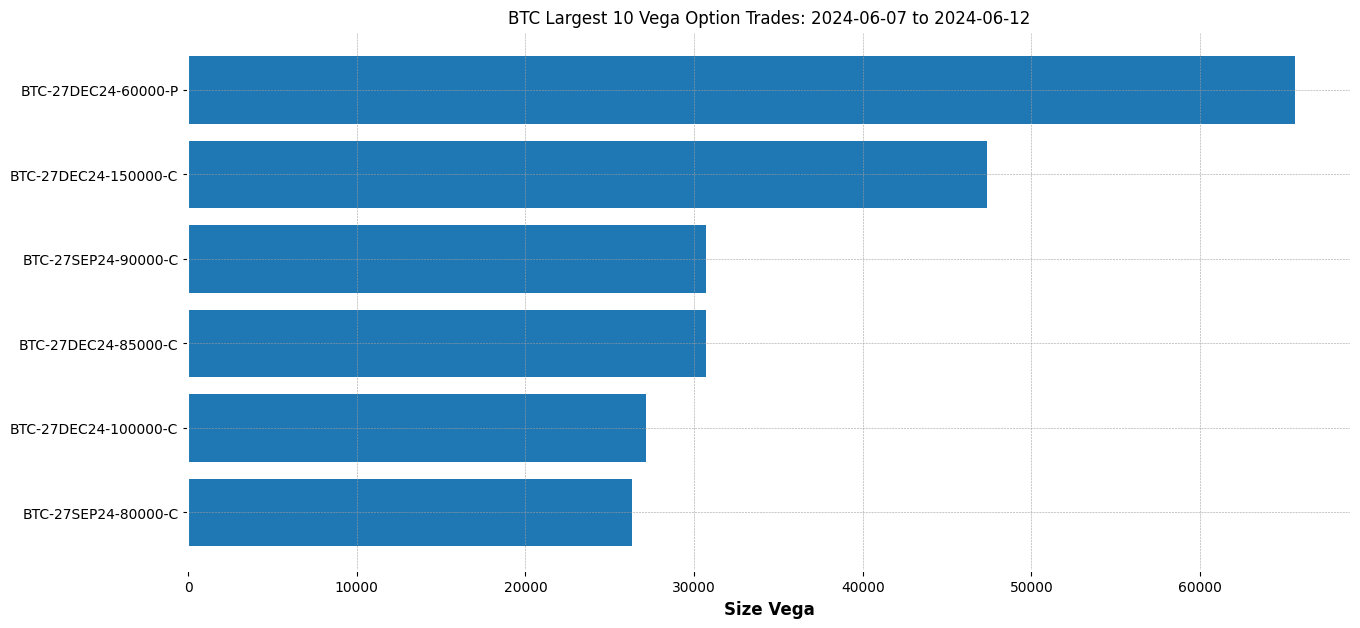

In [37]:
# plot top 10 largest vega trades
data = amberdata_client.get_options_scanner_top_trades(exchange='deribit', currency='btc', startDate='2024-06-07', endDate='2024-06-12')
data = pd.DataFrame(data['payload']['data'])
# only look at top 10 
data = data.sort_values("sizeVega", ascending=False).head(10).reset_index(drop=True)
# sort by descending order 
plt.figure(figsize=(15, 7))
plt.barh(data.instrument, data.sizeVega[::-1])
plt.title("BTC Largest 10 Vega Option Trades: 2024-06-07 to 2024-06-12")
plt.xlabel("Size Vega")